In [1]:
from azure.storage.file import FileService
from azure.storage.file import ContentSettings

import cv2
import numpy as np

In [2]:
file_service = FileService(account_name='covidmodels', account_key='cem1AQ/4Kb+OwutpMredIKiWqeEvP29BGfaCOudw0NIHyo1U+tMF6tbheJF4zeR42L6TIEv+/MPIDdLnCnO5xw==')

In [3]:
data = []
labels = []

In [4]:
import os
kaggle_data = os.listdir('./kaggle_data/')
azure_data = file_service.list_directories_and_files('covid-share/data')

for i, file_or_dir in enumerate(azure_data):
    print(f'COIVD - {file_or_dir.name} | NORMAL - {kaggle_data[i]}')
    
    # Getting file from storage
    byte_data = file_service.get_file_to_bytes('covid-share', 
                                               'data', 
                                               file_or_dir.name).content
    np_bytes = np.fromstring(byte_data, np.uint8)
    
    # Reshape
    az_img = cv2.imdecode(np_bytes, cv2.COLOR_BGR2RGB)
    az_img = cv2.resize(az_img, (224, 224))
    
    data.append(az_img)
    labels.append(1)
    
    kag_img = cv2.imread('./kaggle_data/' + kaggle_data[i])
    kag_img = cv2.cvtColor(kag_img, cv2.COLOR_BGR2RGB)
    kag_img = cv2.resize(kag_img, (224, 224))

    data.append(kag_img)
    labels.append(0)
    
#     break

COIVD - 01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg | NORMAL - IM-0166-0001.jpeg


/home/k4rth33k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


COIVD - 03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg | NORMAL - IM-0608-0001.jpeg
COIVD - 1-s2.0-S0140673620303706-fx1_lrg.jpg | NORMAL - IM-0294-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr2_lrg-a.jpg | NORMAL - IM-0278-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr2_lrg-b.jpg | NORMAL - IM-0475-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr2_lrg-c.jpg | NORMAL - IM-0640-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr2_lrg-d.jpg | NORMAL - IM-0149-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr3_lrg-a.jpg | NORMAL - IM-0482-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr3_lrg-b.jpg | NORMAL - IM-0645-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr3_lrg-c.jpg | NORMAL - IM-0509-0001-0001.jpeg
COIVD - 1-s2.0-S0929664620300449-gr3_lrg-d.jpg | NORMAL - IM-0241-0001.jpeg
COIVD - 1-s2.0-S1684118220300608-main.pdf-001.jpg | NORMAL - IM-0392-0001.jpeg
COIVD - 1-s2.0-S1684118220300608-main.pdf-002.jpg | NORMAL - IM-0429-0001.jpeg
COIVD - 1-s2.0-S1684118220300682-main.pdf-002-a1.png | NORMAL - IM-0395-0001

COIVD - covid-19-pneumonia-evolution-over-a-week-1-day0-L.jpg | NORMAL - IM-0474-0001.jpeg
COIVD - covid-19-pneumonia-evolution-over-a-week-1-day0-PA.jpg | NORMAL - IM-0553-0001-0003.jpeg
COIVD - covid-19-pneumonia-evolution-over-a-week-1-day3.jpg | NORMAL - IM-0523-0001-0003.jpeg
COIVD - covid-19-pneumonia-evolution-over-a-week-1-day4.jpg | NORMAL - IM-0330-0001.jpeg
COIVD - covid-19-pneumonia-rapidly-progressive-12-hours.jpg | NORMAL - IM-0641-0001.jpeg
COIVD - covid-19-pneumonia-rapidly-progressive-3-days.jpg | NORMAL - IM-0535-0001.jpeg
COIVD - covid-19-pneumonia-rapidly-progressive-admission.jpg | NORMAL - IM-0238-0001.jpeg
COIVD - covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-admission.jpg | NORMAL - IM-0325-0001.jpeg
COIVD - covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-1.jpg | NORMAL - IM-0578-0001.jpeg
COIVD - covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-2.jpg | NORMAL - IM-0439-0001-0001.jpeg
COI

In [5]:
for i, d in enumerate(data):
    if len(d.shape) == 2:
        x = cv2.cvtColor(d, cv2.COLOR_BGR2RGB)
        data[i] = x

data = np.array(data).astype('float')
labels = np.array(labels).astype('float')

print('Data:', data.shape)
print('Labels', labels.shape)

Data: (328, 224, 224, 3)
Labels (328,)


In [6]:
data = data / 255

In [72]:
import pickle

# pickle.dump(data, open('data.pkl', 'wb'))
# pickle.dump(labels, open('labels.pkl', 'wb'))

data = pickle.load( open( "data.pkl", "rb" ) )
labels = pickle.load( open( "labels.pkl", "rb" ) )

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [75]:
INIT_LR = 1e-3
EPOCHS = 4
BS = 10

In [76]:
baseModel = VGG16(weights="imagenet", include_top=False,
                    input_tensor=Input(shape=(224, 224, 3)))

In [77]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [78]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [79]:
for layer in baseModel.layers:
    layer.trainable = False

In [80]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])

In [81]:
print(X_train.shape)
print(y_train.shape)


(295, 224, 224, 3)
(295,)


In [82]:
H = model.fit(X_train, y_train, batch_size=BS,
        validation_split=0.1,
        epochs=EPOCHS)

Train on 265 samples, validate on 30 samples
Epoch 1/4
265/265 [==============================] - 135s 508ms/step - loss: 0.6082 - acc: 0.7245 - val_loss: 0.4500 - val_acc: 0.9000
Epoch 2/4
265/265 [==============================] - 182s 687ms/step - loss: 0.3658 - acc: 0.9245 - val_loss: 0.2948 - val_acc: 0.9667
Epoch 3/4
265/265 [==============================] - 174s 655ms/step - loss: 0.2440 - acc: 0.9509 - val_loss: 0.1713 - val_acc: 1.0000
Epoch 4/4
265/265 [==============================] - 200s 753ms/step - loss: 0.1696 - acc: 0.9698 - val_loss: 0.1224 - val_acc: 1.0000


In [83]:
pred = model.predict(X_test, batch_size=BS)
pred = np.where(predIdxs < 0.5, 0, 1)

In [84]:
cm = confusion_matrix(y_test, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [85]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[15  0]
 [ 1 17]]
acc: 0.9697
sensitivity: 1.0000
specificity: 0.9444


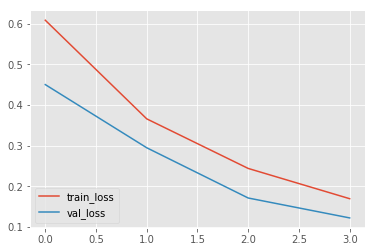

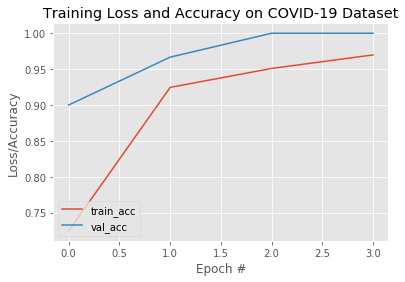

In [86]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.legend(loc="lower left")

plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [87]:
from tensorflow.keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

In [88]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [89]:
frozen_graph = freeze_session(tf.keras.backend.get_session(),
                              output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 94 variables.
INFO:tensorflow:Converted 94 variables to const ops.


In [90]:
from datetime import datetime
timestamp = str(datetime.now().strftime("%d_%m_%Y__%H_%M_%S"))
model_name = 'tf_model_' + timestamp + '.pb'
model_name
path = tf.train.write_graph(frozen_graph, ".", model_name, as_text=False)

In [91]:
print(f'Model saved to {path}')

Model saved to ./tf_model_31_03_2020__12_38_09.pb


In [92]:
azure_models = file_service.list_directories_and_files('covid-share/model')

for file in azure_models:
    print(f'Deleting {file.name}')
    file_service.delete_file('covid-share', 'model', file.name)

Deleting tf_model_31_03_2020__12_07_55.pb


In [93]:
def upload_to_azure(filename):
	print(f'Uploading {filename}')

	file_service.create_file_from_path(
	    'covid-share',
	    'model', 
	    filename,
	    filename)

In [94]:
upload_to_azure(path[2:])

Uploading tf_model_31_03_2020__12_38_09.pb
